In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text

import sys

import pygad
import time

from tqdm import tqdm

from itertools import product

import optuna

import warnings
warnings.filterwarnings('ignore')


c:\Users\user\Desktop\RL_PINN\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
eta_d = 4.5 / 100                     # detection efficiency of single-photon detector (%)
Y_0 = 1.7e-6
e_d = 3.3 / 100                       # misalignment rate
alpha = 0.21                          # attenuation coefficient of single-mode fiber
zeta = 1.22                           # efficiency of error correction
eps_sec = 1e-10
eps_cor = 1e-15
N = 1e10                              # number of optical pulses sent by Alice

eps = eps_sec/23                 
beta = np.log(1/eps)

Lambda = None                          # probability of bit value 1 observed in Xk
L = 100                                # fiber length (0~110)
e_0 = 0.5                              # ref 23 참고, error rate of the background, background가 랜덤한 경우 가정

In [4]:
def normalize_p(vec) :

    copy_vec = vec[:].copy()

    sum_vec = np.sum(copy_vec[3:6])
    copy_vec[3:6] /= sum_vec
    return copy_vec

def h(x) :
    return -x * np.log2(x) - (1 - x)*np.log2(1 - x)

In [5]:
def calc_SKR(ga_instance, solution, solution_idx) :

    sol = normalize_p(solution)
    mu, nu, vac, p_mu, p_nu, p_vac, p_X, q_X = sol

    p_Z = 1 - p_X
    q_Z = 1 - q_X

    if mu <= nu : 
        return -10

    eta = eta_d * 10 ** (-alpha*L/10)

    Q_mu = 1 - (1 - Y_0) * np.exp(-mu * eta)
    Q_nu = 1 - (1 - Y_0) * np.exp(-nu * eta)
    Q_vac = 1 - (1 - Y_0) * np.exp(-vac * eta)

    n_mu_Z = N * p_mu * p_Z * q_Z * Q_mu
    n_nu_Z = N * p_nu * p_Z * q_Z * Q_nu
    n_vac_Z = N * p_vac * p_Z * q_Z * Q_vac

    n_mu_X = N * p_mu * p_X * q_X * Q_mu
    n_nu_X = N * p_nu * p_X * q_X * Q_nu
    n_vac_X = N * p_vac * p_X * q_X * Q_vac

    if (n_mu_Z<0) or (n_nu_Z<0) or (n_vac_Z<0) or (n_mu_X<0) or (n_nu_X<0) or (n_vac_X<0) :
        return -8
    
    m_mu_Z = N * p_mu * p_Z * q_Z * (e_d * Q_mu + (e_0 - e_d)*Y_0)
    m_nu_Z = N * p_nu * p_Z * q_Z * (e_d * Q_nu + (e_0 - e_d)*Y_0)
    m_nu_X = N * p_nu * p_X * q_X * (e_d * Q_nu + (e_0 - e_d)*Y_0)

    if (m_mu_Z<0) or (m_nu_Z<0) or (m_nu_X<0) :
        return -8
    
    # Z-basis lower bound
    n_0_z_L_ex = n_vac_Z - beta/2-np.sqrt(2*beta*n_vac_Z+beta**2/4)
    n_nu_z_L_ex = n_nu_Z - beta/2-np.sqrt(2*beta*n_nu_Z+beta**2/4)

    # Z-basis upper bound
    n_mu_z_U_ex = n_mu_Z + beta+np.sqrt(2*beta*n_mu_Z+beta**2)
    n_0_z_U_ex = n_vac_Z + beta+np.sqrt(2*beta*n_vac_Z+beta**2)

    # X-basis lower bound
    n_0_x_L_ex = n_vac_X - beta/2-np.sqrt(2*beta*n_vac_X+beta**2/4)
    n_nu_x_L_ex = n_nu_X - beta/2-np.sqrt(2*beta*n_nu_X+beta**2/4)                 

    # X-basis upper bound
    n_mu_x_U_ex = n_mu_X + beta+np.sqrt(2*beta*n_mu_X+beta**2)
    n_0_x_U_ex = n_vac_X + beta+np.sqrt(2*beta*n_vac_X+beta**2)

    # error upper bound
    m_nu_x_U_ex = m_nu_X + beta+np.sqrt(2*beta*m_nu_X+beta**2)

    if (n_0_z_L_ex<0) or (n_nu_z_L_ex<0) or (n_mu_z_U_ex<0) or (n_0_z_U_ex<0) or (n_0_x_L_ex<0) or (n_nu_x_L_ex<0) or (n_mu_x_U_ex<0) or (n_0_x_U_ex<0) or (m_nu_x_U_ex<0) :
        return -7
    
    # lower bound on the expected number of vacuum event
    S_0_Z_L_ex = (np.exp(-mu)*p_mu+np.exp(-nu)*p_nu)*p_Z*n_0_z_L_ex/p_vac
    # lower bound on the expected number of single photon event
    S_1_Z_L_ex = (mu**2*np.exp(-mu)*p_mu+mu*nu*np.exp(-nu)*p_nu)/(mu*nu-nu**2)*(np.exp(nu)*n_nu_z_L_ex/p_nu-nu**2/mu**2*np.exp(mu)*n_mu_z_U_ex/p_mu-(mu**2-nu**2)/mu**2*p_Z*n_0_z_U_ex/p_vac)
    # lower bound on the expected number of single-photon events
    S_1_X_L_ex = (mu**2*np.exp(-mu)*p_mu+mu*nu*np.exp(-nu)*p_nu)/(mu*nu-nu**2)*(np.exp(nu)*n_nu_x_L_ex/p_nu-nu**2/mu**2*np.exp(mu)*n_mu_x_U_ex/p_mu-(mu**2-nu**2)/mu**2*p_X*n_0_x_U_ex/p_vac)
    # upper bound on the expected number of bit error
    T_1_X_U_ex = ((mu*np.exp(-mu)*p_mu+nu*np.exp(-nu)*p_nu)/nu)*(np.exp(nu)*m_nu_x_U_ex/p_nu-p_X*n_0_x_L_ex/(2*p_vac))

    if (S_0_Z_L_ex<0)or(S_1_Z_L_ex<0)or(S_1_X_L_ex<0)or(T_1_X_U_ex<0) : 
        return -6

    S_0_Z_L = S_0_Z_L_ex - np.sqrt(2*beta*S_0_Z_L_ex)
    S_1_Z_L = S_1_Z_L_ex - np.sqrt(2*beta*S_1_Z_L_ex)
    S_1_X_L = S_1_X_L_ex - np.sqrt(2*beta*S_1_X_L_ex)
    T_1_X_U = T_1_X_U_ex + beta/2+np.sqrt(2*beta*T_1_X_U_ex+beta**2/4)

    if (S_0_Z_L<0)or(S_1_Z_L<0)or(S_1_X_L<0)or(T_1_X_U<0) : 
        return -5

    n = S_1_Z_L
    k = S_1_X_L
    Lambda = T_1_X_U/S_1_X_L

    if (n < 0) or (k < 0) : 
        return -4

    A = np.max([n,k])
    G = (n+k)/(n*k) * np.log((n+k) / (2*np.pi*n*k*Lambda*(1-Lambda)*eps**2))

    gamma_U = (((1 - 2 * Lambda)*A*G)/(n+k) + np.sqrt(A**2*G**2/(n+k)**2 + 4*Lambda*(1-Lambda)*G))/ (2 + 2*A**2*G/(n + k)**2)

    phi_1_Z_U =  Lambda + gamma_U
    if (phi_1_Z_U > 0.5) or (phi_1_Z_U <0):
        return -3

    # 생성된 키 길이 계산
    n_Z = n_mu_Z + n_nu_Z
    E_Z = (m_mu_Z + m_nu_Z)/n_Z

    lambda_ec = n_Z * zeta * h(E_Z)

    length = S_0_Z_L + S_1_Z_L * (1 - h(phi_1_Z_U)) - lambda_ec - np.log2(2/eps_cor) - 6*np.log2(23/eps_sec)

    if (length > N) or (length < 0) : 
        return -2

    SKR = length/N

    if np.isnan(SKR) or np.isinf(SKR):
        return -1

    return SKR

In [7]:
def define_ga(co_type, mu_type, sel_type, 
              gen = 100,
              num_parents_mating = 60, sol_per_pop = 200, keep_parents = 50, keep_elitism = 10, K_tournament = 8, crossover_probability = 0.8, mutation_probability = 0.02, mutation_percent_genes = "default",
              make_df = False, df = None, random_seed = 42) :

    def append_df(ga_instance, last_gen_fitness):
        nonlocal df  
        if df is not None:
            data = dict(zip(['mu', 'nu', 'vac', 'p_mu', 'p_nu', 'p_vac', 'p_x', 'q_x'], normalize_p(ga_instance.best_solution()[0])))
            data['SKR'] = ga_instance.best_solution()[1]
            data['L'] = L
            df.loc[len(df)] = data


    if make_df == True : 
        on_stop = append_df
    if make_df == False :
        on_stop = None
    
    ga_instance = pygad.GA(num_generations = gen,   #(논문 : 최대 1000)                    # 세대 수
                    num_parents_mating = num_parents_mating,   #(논문 : 30)               # 부모로 선택될 솔루션의 수

                    fitness_func = calc_SKR,
                    fitness_batch_size = None,                                           # 배치 단위로 적합도 함수를 계산, 적합도 함수는 각 배치에 대해 한 번씩 호출

                    initial_population = None,                                           # 사용자 정의 초기 개체군, num_genes와 크기가 같아야 함
                    sol_per_pop = sol_per_pop,                                           # 한 세대에 포함되는 솔루션(염색체)의 수, 크면 탐색 다양성이 높아짐, 작으면 빠르게 수렴하지만 최적해를 놓칠 수 있음, initial population이 있으면 작동하지 않음
                    num_genes = 8,                                                       # 염색체 내 유전자 수, initial_population을 사용하는 경우 이 매개변수가 필요하지 않음
                    gene_type = [float, 6],                                              # 유전자 유형, 각 개별 유전자의 데이터 유형 및 소수점도 지정 가능, 리스트 형식 e.g. [int, float, bool, int]

                    init_range_low = 0,                                                  # 초기 모집단의 유전자 값이 선택되는 임의 범위의 하한, initial_population이 있으면 필요 없음
                    init_range_high = 1,                                                 # 초기 모집단의 유전자 값이 선택되는 임의 범위의 상한,

                    parent_selection_type = sel_type,                                    # 부모 선택 유형, sss (for steady-state selection), rws (for roulette wheel selection), sus (for stochastic universal selection), rank (for rank selection), random (for random selection), and tournament (for tournament selection)
                    keep_parents = keep_parents,                                         # 현재 개체군에 유지할 부모의 수, -1 : 모든 부모를 개체군에 유지, keep_elitism이 0인 경우에만 작동
                    keep_elitism = keep_elitism,                                         # k : 현재 세대의 k개의 best solution만 다음 세대로 이어짐, 0 <= keep_elitism <= sol_per_pop

                    K_tournament = K_tournament,                                         # parent_selection_type이 tournament인 경우에 토너먼트에 참여하는 부모의 수

                    crossover_type = co_type,                                            # 교차 연산 유형, single_point (for single-point crossover), two_points (for two points crossover), uniform (for uniform crossover), and scattered (for scattered crossover)
                    crossover_probability = crossover_probability,   #(논문 : 0.8)        # 교차 연산을 적용할 부모 노드를 선택할 확률, 나머지 확률은 부모 유전자를 그대로 복제해서 다음 세대로 넘김

                    mutation_type = mu_type,                                             # 돌연변이 연산의 유형, random (for random mutation), swap (for swap mutation), inversion (for inversion mutation), scramble (for scramble mutation), and adaptive (for adaptive mutation)
                    mutation_probability = mutation_probability,   #(논문 : 0.02)         # 돌연변이 연산을 적용할 유전자(개체) 선택 확률, 돌연변이 함수 정의 가능, 이 변수가 있으면 mutation_percent_genes와 mutation_num_genes 필요 없음
                    mutation_by_replacement = True,                                      # mutation_type이 random일 때만 작동, True면 기존 유전자를 돌연변이로 대체, False면 기존 유전자에 노이즈 추가
                    mutation_percent_genes = mutation_percent_genes,                     # 돌연변이 대상 개체 내에서 변이할 유전자의 비율 (default : 10%), 여기서 돌연변이할 유전자의 개수가 계산되어 mutation_num_genes에 할당됨
                    mutation_num_genes = None,                                           # 돌연변이할 유전자의 개수 지정, mutation_probability 변수가 있는 경우 작동하지 않음
                    random_mutation_min_val = -0.5,                                      # 유전자에 추가될 난수 값이 선택되는 범위의 하한
                    random_mutation_max_val = 0.5,                                       # 유전자에 추가될 난수 값이 선택되는 범위의 상한

                    gene_space = [{'low': 0, 'high': 1}] * 8,

                    on_start = None,                                                     # 유전 알고리즘이 진화를 시작하기 전에 한 번만 호출되는 함수/메서드
                    on_fitness = None,                                                   # 모집단 내 모든 해의 적합도 값을 계산한 후 호출할 함수/메서드를 받음
                    on_parents = None,                                                   # 부모를 선택한 후 호출할 함수/메서드
                    on_crossover = None,                                                 # 교차 연산이 적용될 때마다 호출될 함수
                    on_mutation = None,                                                  # 돌연변이 연산이 적용될 때마다 호줄될 함수
                    on_generation = None,                                                # 각 세대마다 호출될 함수
                    on_stop = on_stop,                                                   # 유전 알고리즘이 종료되기 바로 전이나 모든 세대가 완료될 때 한번만 호출되는 함수

                    save_best_solutions = True,                                          # True인 경우 각 세대 이후 best_solution에 최적해 저장
                    save_solutions = True,                                               # 각 세대의 모든 해는 solution에 저장

                    suppress_warnings = False,
                    allow_duplicate_genes = False,                                       # True인 경우, solution/염색체에 중복된 유전자 값이 있을 수 있음

                    stop_criteria = None,
                    parallel_processing = None,                                          # None인 경우 병렬 처리 허용하지 않음

                    random_seed = random_seed,

                    logger = None                                                        # logger 허용
                    )
    return ga_instance

In [8]:
ref = [3e-3, 1.7e-3, 9e-4, 5e-4, 2.9e-4, 1.7e-4, 8e-5, 4e-5, 1.9e-5, 8e-6, 3e-6, 3e-7]

def plot_SKR(skr_list, title = '  ', save = False) : 
    plt.figure(figsize=(10, 6))

    x_ga = np.arange(0, len(skr_list) * 5, 5)  
    x_ref = np.arange(0, len(ref) * 10, 10)               

    plt.plot(x_ga, skr_list, marker='o', color='blue', label='ga')
    plt.plot(x_ref, ref, marker='s', color='red', label='ref')
    plt.yscale('log')
    plt.legend()

    texts = []
    for x, ga in zip(x_ga, skr_list):
        texts.append(plt.text(x, ga, f'{ga:.1e}', fontsize=8, color='blue'))

    for x, r in zip(x_ref, ref):
        texts.append(plt.text(x, r, f'{r:.1e}', fontsize=8, color='red'))

    adjust_text(texts,
                arrowprops=dict(arrowstyle='-', color='gray', lw=0.5)
    )

    plt.xlabel('L')
    plt.ylabel('SKR')

    max_x = max(x_ga[-1], x_ref[-1])
    plt.xticks(np.arange(0, max_x + 1, 10))

    plt.title(f'SKR Comparison\n{title}')
    plt.grid(True, which="both", ls="--", linewidth=0.5)
    plt.tight_layout()

    if save == True : 
        plt.savefig(f'{title}.png')
    
    plt.show()


In [9]:
def make_df() : 
    df = pd.DataFrame(columns=['L', 'mu', 'nu', 'vac', 'p_mu', 'p_nu', 'p_vac', 'p_x', 'q_x', 'SKR'])
    return df

In [ ]:
L_limit = 150  
n = 31         
num_iter = 3   


def objective(trial):
    total_fitness = 0
    
    crossover_type = trial.suggest_categorical("crossover_type", ["single_point", "two_points", "uniform", "scattered"])
    mutation_type = trial.suggest_categorical("mutation_type", ["random", "swap", "inversion", "scramble", "adaptive"])
    parent_selection_type = trial.suggest_categorical("parent_selection_type", ["sss", "rws", "sus", "rank", "random", "tournament"])

    sol_per_pop = trial.suggest_int("sol_per_pop", 80, 250)
    num_parents_mating = trial.suggest_int("num_parents_mating", int(sol_per_pop*0.2), sol_per_pop)
    keep_parents = trial.suggest_int("keep_parents", 1, num_parents_mating)
    keep_elitism = trial.suggest_int("keep_elitism", 0, 20)    
    crossover_probability = trial.suggest_float("crossover_probability", 0.2, 1)

    # mutation 
    if mutation_type == "adaptive":
        mutation_percent_genes = trial.suggest_categorical("mutation_percent_genes", [[0.5, 0.05], [0.3, 0.1], [0.7, 0.2]])
        mutation_probability = None
    else:
        mutation_percent_genes = "default"
        mutation_probability = trial.suggest_float("mutation_probability", 0.01, 0.5)

    # tournament
    K_tournament = trial.suggest_int("K_tournament", 2, int(num_parents_mating * 0.7)) if parent_selection_type == "tournament" else None

    for L in np.linspace(0, L_limit, n):
        for _ in range(num_iter):

            ga = define_ga(co_type=crossover_type,
                           mu_type=mutation_type,
                           sel_type=parent_selection_type,
                           gen = 100,
                           num_parents_mating=num_parents_mating,
                           sol_per_pop=sol_per_pop,
                           keep_parents=keep_parents,
                           keep_elitism=keep_elitism,
                           K_tournament=K_tournament,
                           crossover_probability=crossover_probability,
                           mutation_probability=mutation_probability,
                           mutation_percent_genes=mutation_percent_genes,
                           make_df=False,
                           df=None,
                           random_seed=None)

            ga.run()
            best_fitness = ga.best_solution()[1]
            total_fitness += best_fitness

    return - total_fitness 

In [12]:
sampler = optuna.samplers.TPESampler(n_startup_trials=20,  
                                     multivariate=True,    
                                     group=True)

study = optuna.create_study(sampler = sampler, direction="minimize")
study.optimize(objective, n_trials=50)

print("Best trial:")
print(study.best_trial)

[I 2025-09-08 15:47:48,488] A new study created in memory with name: no-name-36362e47-ceac-484c-bb9d-d7f7115b643c
[W 2025-09-08 15:47:54,748] Trial 0 failed with parameters: {'crossover_type': 'uniform', 'mutation_type': 'scramble', 'parent_selection_type': 'tournament', 'sol_per_pop': 99, 'num_parents_mating': 49, 'keep_parents': 4, 'keep_elitism': 2, 'crossover_probability': 0.7146434586360648, 'mutation_probability': 0.248683780297854, 'K_tournament': 18} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "c:\Users\user\Desktop\RL_PINN\venv\lib\site-packages\optuna\study\_optimize.py", line 201, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\user\AppData\Local\Temp\ipykernel_15256\1784125376.py", line 49, in objective
    ga.run()
  File "c:\Users\user\Desktop\RL_PINN\venv\lib\site-packages\pygad\pygad.py", line 1814, in run
    self.last_generation_fitness = self.cal_pop_fitness()
  File "c:\Users\user\Desktop\RL_PINN\ve

KeyboardInterrupt: 

In [19]:
study = {'crossover_type': 'two_points',
 'mutation_type': 'adaptive',
 'parent_selection_type': 'sss',
 'sol_per_pop': 218,
 'num_parents_mating': 61,
 'keep_parents': 44,
 'keep_elitism': 17,
 'crossover_probability': 0.8546404973857875,
 'mutation_percent_genes': [0.7, 0.2]}

In [48]:
optuna.visualization.plot_optimization_history(study)

In [109]:
optuna.visualization.plot_param_importances(study)

In [ ]:
skr_list = []

df = make_df()

L_limit = 150
n = 31

num_iter = 1

for i in tqdm(range(num_iter)) :
    for L in tqdm(np.linspace(0, L_limit, n)) :
        ga_instance = define_ga(co_type = study['crossover_type'],
                                mu_type = study['mutation_type'],
                                sel_type = study['parent_selection_type'],
                                gen = 100,
                                num_parents_mating = study['num_parents_mating'],
                                sol_per_pop = study['sol_per_pop'],
                                keep_parents = study['keep_parents'],
                                keep_elitism = study['keep_elitism'],
                                crossover_probability = study['crossover_probability'],
                                mutation_probability = None,
                                mutation_percent_genes = study['mutation_percent_genes'],
                                make_df = True, df = df, random_seed = 42)
        ga_instance.run()
        solution, solution_fitness, solution_idx = ga_instance.best_solution()

skr_list = df.groupby('L').max('SKR')['SKR']

100%|██████████| 1/1 [15:20<00:00, 920.17s/it]


29 [-0.63772901  0.06371506]
30 [-0.21011935 -0.98634545]


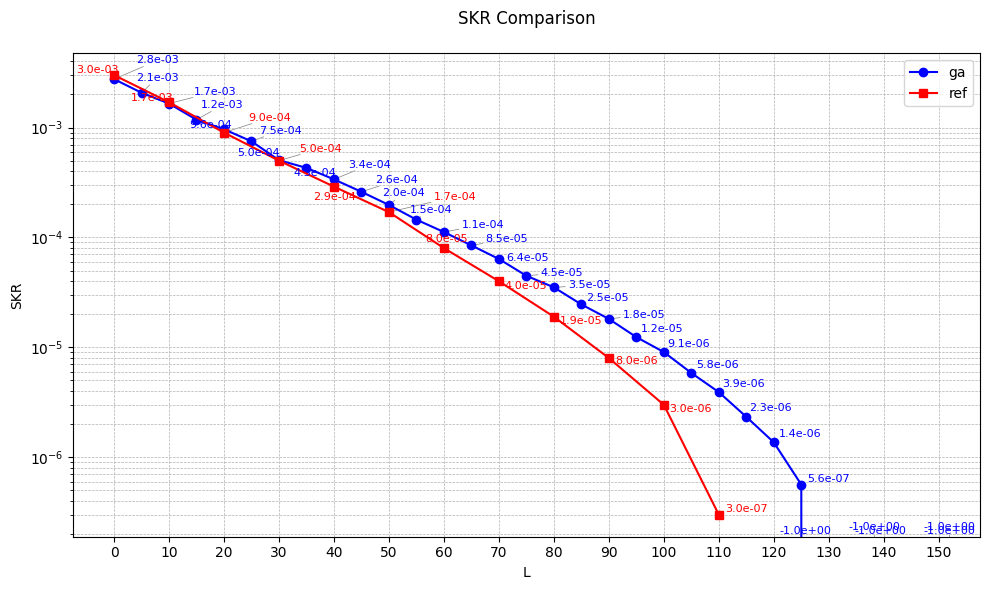

In [21]:
plot_SKR(skr_list)

29 [ 0.35613272 -0.82619876]
30 [ 0.79599142 -0.10200627]


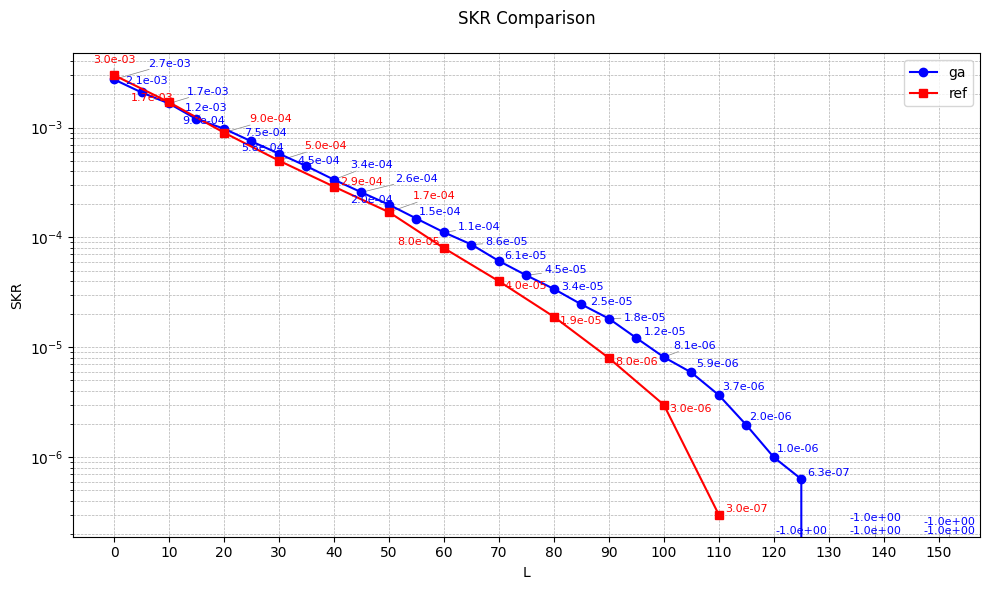

In [16]:
plot_SKR(skr_list)

In [22]:
print(solution)
s=calc_SKR(3, solution,solution_idx )
print(s)

[0.412272 0.090757 0.040941 0.098549 0.871253 0.164952 0.438019 0.139523]
-1
